## KDD CUP 99 attacked connection detetion using AE, GMM, and VAE
Here is just the demo to run and show our modeling, more details are in the specific branch.

In [10]:
import numpy as np
import pandas as pd
import torch
from data_loader import *
from main import *
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


## preprocessing
(can be skiped in the demo)

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv(
    "kddcup.data_10_percent_corrected",
    header=None,
    names=[
        'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
        'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
        'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
        'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
        'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
        'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
        'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
        'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'type'
    ],
    nrows=40000
)

# Convert 'type' into a binary indicator where 'normal.' is 0 and others are 1
data['type'] = data['type'].apply(lambda x: 0 if x == "normal." else 1)

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['protocol_type', 'service', 'flag'])

# Display the first few rows of the updated DataFrame
data.head()

,icmp,tcp,udp,auth,domain_u,eco_i,ecr_i,finger,ftp,http,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type
0,False,True,False,False,False,False,False,False,False,True,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,1
1,False,True,False,False,False,False,False,False,False,True,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,1
2,False,True,False,False,False,False,False,False,False,True,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1
3,False,True,False,False,False,False,False,False,False,True,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1
4,False,True,False,False,False,False,False,False,False,True,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
# Calculate proportions of the 'type' classifications
proportions = data['type'].value_counts(normalize=True)

# Define columns for normalization
cols_to_norm = [
    "duration", "src_bytes", "dst_bytes", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "num_compromised", "num_root", "num_file_creations", "num_shells", "num_access_files", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate"
]

# Normalization using min-max scaling based on 'normal.' class (type == 0)
min_cols = data[data['type'] == 0][cols_to_norm].min()
max_cols = data[data['type'] == 0][cols_to_norm].max()

# Apply min-max scaling
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - min_cols) / (max_cols - min_cols))


In [ ]:
! pip install pandas==0.22.0

# RUN THE MODEL
pre requirement: loading the npz dataset as the scale you like

In the ipynb, we used 40k-item dataset to measure performance

Elapsed 0:35:28.094601/0:00:00.164552 -- 0:00:00.164552 , Epoch [200/200], Iter [192/194], lr 0.0001, total_loss: 0.0754, sample_energy: -0.0586, recon_error: 0.0273, cov_diag: 10.7779


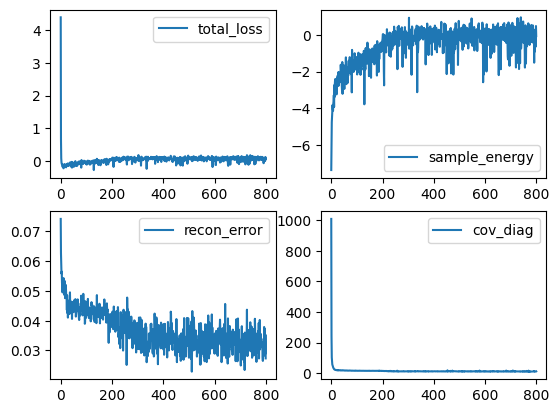

100%|██████████| 194/194 [00:10<00:00, 18.52it/s]

phi tensor([0.9915, 0.0042, 0.0022, 0.0021]) mu tensor([[-1.5510,  0.3215,  0.4736],
        [-0.0579,  0.9165,  0.0770],
        [-0.2598,  0.9067,  0.1478],
        [-0.2893,  0.8518,  0.1504]]) cov tensor([[[ 8.8284,  1.4130, -2.5136],
         [ 1.4130,  0.2886, -0.3965],
         [-2.5136, -0.3965,  0.7179]],

        [[ 9.8879,  1.3933, -2.7884],
         [ 1.3933,  1.5523, -0.2458],
         [-2.7884, -0.2458,  0.8133]],

        [[ 9.7761,  1.5534, -2.7728],
         [ 1.5534,  1.8175, -0.2611],
         [-2.7728, -0.2611,  0.8105]],

        [[ 9.9356,  1.5582, -2.8221],
         [ 1.5582,  1.5906, -0.2883],
         [-2.8221, -0.2883,  0.8227]]])
======================TEST MODE======================


N: 198371
phi :
 tensor([9.9797e-01, 8.2702e-04, 5.7205e-04, 6.3454e-04],
       grad_fn=<DivBackward0>)
mu :
 tensor([[-1.5265,  0.3384,  0.4679],
        [-0.4348,  3.1310,  0.4507],
        [-0.1773,  3.1308,  0.3873],
        [-0.0938,  3.1693,  0.3667]], grad_fn=<DivBackward0>)
cov :
 tensor([[[ 8.8741,  1.4351, -2.5213],
         [ 1.4351,  0.3494, -0.3965],
         [-2.5213, -0.3965,  0.7194]],

        [[ 4.2273,  1.2377, -1.0563],
         [ 1.2377,  4.4917,  0.2057],
         [-1.0563,  0.2057,  0.3460]],

        [[ 4.5276,  0.8115, -1.2498],
         [ 0.8115,  4.6591,  0.3245],
         [-1.2498,  0.3245,  0.4188]],

        [[ 4.4731,  0.5934, -1.2595],
         [ 0.5934,  4.5737,  0.3804],
         [-1.2595,  0.3804,  0.4283]]], grad_fn=<DivBackward0>)
Threshold : 5.747354984283447
Accuracy : 0.9824, Precision : 0.9769, Recall : 0.9693, F-score : 0.9731


In [11]:
class hyperparams():
    def __init__(self, config):
        self.__dict__.update(**config)
defaults = {
    'lr' : 1e-4,
    'num_epochs' : 200,
    'batch_size' : 1024,
    'gmm_k' : 4,
    'lambda_energy' : 0.1,
    'lambda_cov_diag' : 0.005,
    'pretrained_model' : None,
    'mode' : 'train',
    'use_tensorboard' : False,
    'data_path' : 'kdd_cup.npz',

    'log_path' : './dagmm/logs',
    'model_save_path' : './dagmm/models',
    'sample_path' : './dagmm/samples',
    'test_sample_path' : './dagmm/test_samples',
    'result_path' : './dagmm/results',

    'log_step' : 194//4,
    'sample_step' : 194,
    'model_save_step' : 194,
}

solver = main(hyperparams(defaults))
accuracy, precision, recall, f_score = solver.test()

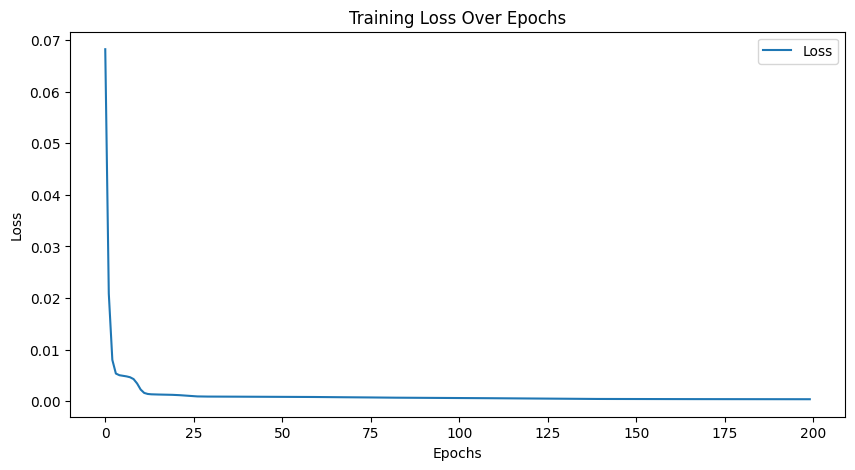

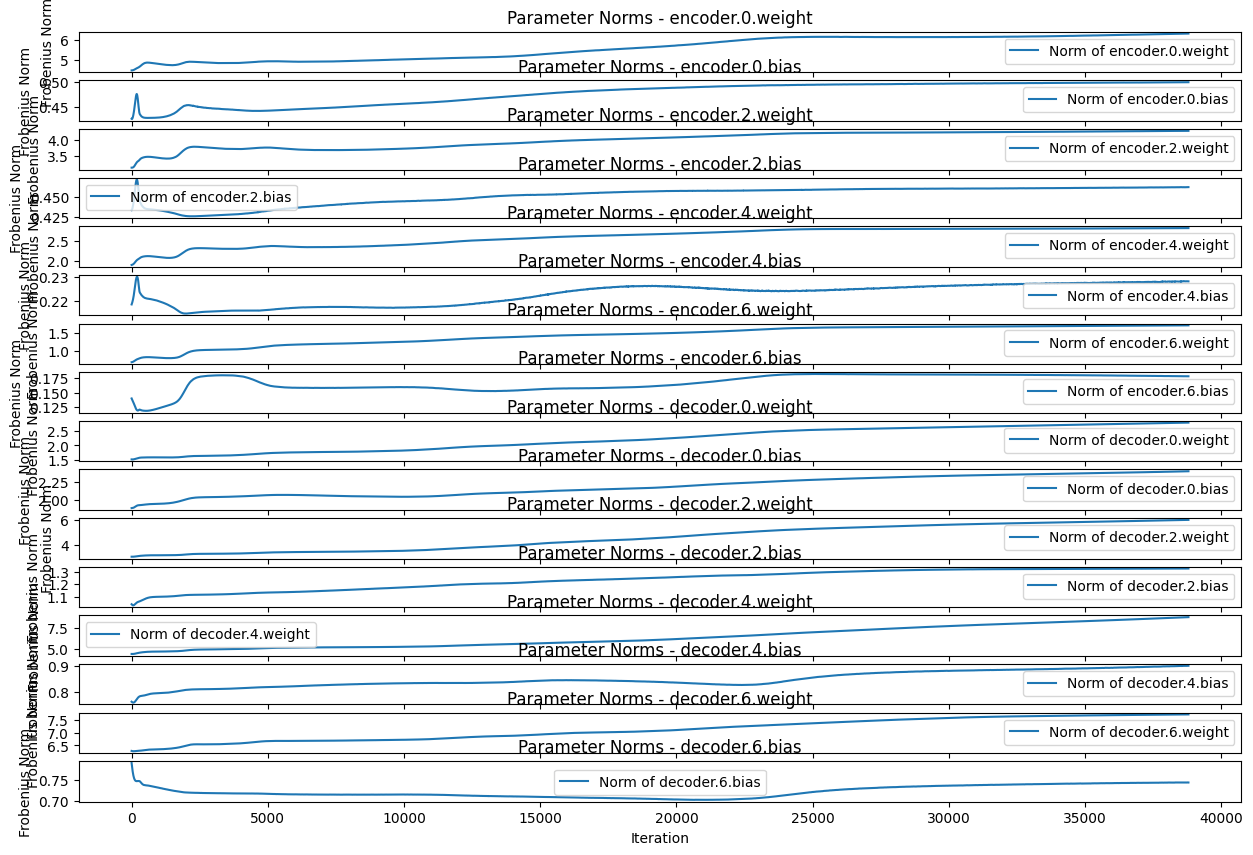

accuracy: 0.8661
precision: 0.9259
recall: 0.7014
f_score: 0.8011


In [7]:
from main_AE import *
from main_AE import main

class hyperparams_AE():
    def __init__(self, config):
        self.__dict__.update(**config)
defaults = {
    'lr': 1e-4,
    'num_epochs': 200,
    'batch_size': 1024,
    'pretrained_model': None,
    'mode': 'train',
    'use_tensorboard': False,

    'data_path': 'kdd_cup.npz',

    'log_path': './ae/logs',
    'model_save_path': './ae/models',
    'sample_path': './ae/samples',
    'test_sample_path': './ae/test_samples',
    'result_path': './ae/results',

    'log_step': 256 // 4,
    'sample_step': 256,
    'model_save_step': 256,
}

solver = main(hyperparams_AE(defaults))
accuracy, precision, recall, f_score = solver_AE.test()

In [ ]:
class hyperparams_VAE():
    def __init__(self, config):
        self.__dict__.update(**config)
defaults = {
    'lr': 1e-4,
    'num_epochs': 200,
    'batch_size': 1024,
    'pretrained_model': None,
    'mode': 'train',
    'use_tensorboard': False,

    'data_path': 'kdd_cup.npz',

    'log_path': './vae/logs',
    'model_save_path': './vae/models',
    'sample_path': './vae/samples',
    'test_sample_path': './vae/test_samples',
    'result_path': './vae/results',

    'log_step': 256 // 4,
    'sample_step': 256,
    'model_save_step': 256,
}

In [ ]:
print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy,precision, recall, f_score))

Accuracy : 0.9743, Precision : 0.9677, Recall : 0.9538, F-score : 0.9607
